<a href="https://colab.research.google.com/github/Kennedy87670/NLP/blob/main/Skimlit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: SkimLit

In [2]:
#confirm GPU
#!nvidia-smi

# getting the data
 the data is goten from: https://github.com/Franck-Dernoncourt/pubmed-rct


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# check what files are in the publised Pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, its time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize Visualize Visualize

so with that in mind, lets write a fuction to read all of the lines of a target text file

In [7]:
# create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing the target filepath.

  Returns:
  Alist of strings with one string per line for the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# lets read in the training lines
train_lines = get_lines(data_dir+ "train.txt") # read the lines within
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

# lets think about how we want our data to look....

#How i think our data would be best created 

[ {'line_number':0,
   'target': 'BACKGROUND',
   "text": 'Emotional eating is associated with overeating and the development of obesity .\n',
   "total_lines": 11},
    ...]
 format

Lets write a function which turns each of our datasets into the above format so we can continue to prepare

In [9]:


def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 641 ms, sys: 216 ms, total: 856 ms
Wall time: 866 ms


(180040, 30212, 30135)

In [11]:
# check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a Datafram to futher visualize

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df =pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

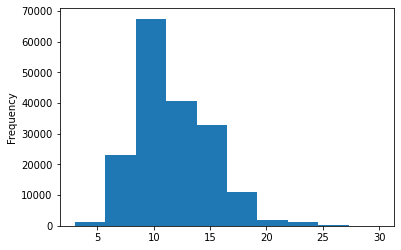

In [14]:
# lets check the length of different lines
train_df.total_lines.plot.hist()

# Get the list of sentences

In [15]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [16]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [17]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
#c check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label Encode labels

In [18]:
# Extract labels ('target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments...

As usual, we are going to be trying out a bunch of different models and seeing which one works best.

And as always, we are going to start with a baseline (TF-IDF Multinomial Naive Bays Classifier)

In [20]:
## Model 0: Getting a baseline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

# Download our helper function

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-29 18:17:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-29 18:17:22 (80.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred =baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [26]:
import numpy as np
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([3.6293e+04, 7.6251e+04, 4.4193e+04, 1.4273e+04, 5.4860e+03,
        1.9400e+03, 8.5400e+02, 3.9100e+02, 1.7400e+02, 8.4000e+01,
        3.7000e+01, 1.9000e+01, 1.3000e+01, 5.0000e+00, 1.1000e+01,
        8.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00]),
 array([  1.        ,  14.40909091,  27.81818182,  41.22727273,
         54.63636364,  68.04545455,  81.45454545,  94.86363636,
        108.27272727, 121.68181818, 135.09090909, 148.5       ,
        161.90909091, 175.31818182, 188.72727273, 202.13636364,
        215.54545455, 228.95454545, 242.36363636, 255.77272727,
        269.18181818, 282.59090909, 296.        ]),
 <a list of 22 Patch objects>)

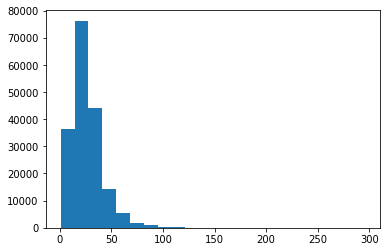

In [28]:
# whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=22)

In [29]:
# How long of the sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:

# Maximum sequence length in the training set
max(sent_lens)

296

import numbers
## Create text vectorization layer

We want to make a layer which maps our text from words to numbers

In [31]:
# How many words are in our vocab? 
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length= output_seq_len)  # desired output lenth of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
our aim is to assess the comparative efficacy of adhesive polyurethane foam and hydrocolloid dressings in the treatment of pru-iis in terms of healed ulcer after @ weeks of follow-up .

Length of text: 31

Vectorized text:
[[  246   267    20     6   216     2  1502    79     4  4051 11460  3985
      3 22932  6214     5     2    19     4 35208     5   614     4  5355
   2983    21    53     4    94     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True, #use masking to handel variable sequence length... remove all zeros
                               name="token_embedding") 



In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
our aim is to assess the comparative efficacy of adhesive polyurethane foam and hydrocolloid dressings in the treatment of pru-iis in terms of healed ulcer after @ weeks of follow-up .

Sentence after vectorization (before embedding):
[[  246   267    20     6   216     2  1502    79     4  4051 11460  3985
      3 22932  6214     5     2    19     4 35208     5   614     4  5355
   2983    21    53     4    94     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00775802  0.01822139  0.0398188  ...  0.04610863 -0.01886369
   -0.04600486]
  [-0.00391481  0.03029862  0.02547106 ...  0.02111283  0.02359423
    0.02859897]
  [ 0.0350993   0.02716025 -0.00295373 ... -0.0307314  -0.03199252
    0.03057834]
  ...
  [ 0.01031321 -0.00129502  0.02976319 ...  0.04709755  0.00699669
    0.00410979]
  [ 0.01031321 -0.00129502 

 ## Creating datasets (making sure our data loads as fast as possible)

 we are goint to setup our data to run as fast as possible with the tensorflow tf.data API, many of the steps are 

In [39]:
import tensorflow as tf


In [40]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [42]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [43]:
# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 88s 154ms/step - loss: 0.9239 - accuracy: 0.6353 - val_loss: 0.6841 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 85s 151ms/step - loss: 0.6596 - accuracy: 0.7565 - val_loss: 0.6310 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 84s 150ms/step - loss: 0.6183 - accuracy: 0.7752 - val_loss: 0.5944 - val_accuracy: 0.7872


In [46]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)


945/945 [==============================] - 7s 7ms/step - loss: 0.5980 - accuracy: 0.7865


[0.5979849100112915, 0.786541759967804]

In [47]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.1599590e-01, 1.8932278e-01, 8.2122549e-02, 2.7029860e-01,
        4.2260241e-02],
       [4.5621338e-01, 2.7210760e-01, 1.2112021e-02, 2.5185716e-01,
        7.7098939e-03],
       [1.4199126e-01, 5.8008055e-03, 2.3118360e-03, 8.4985030e-01,
        4.5808221e-05],
       ...,
       [3.5125761e-06, 5.3098449e-04, 8.4639736e-04, 2.5289910e-06,
        9.9861658e-01],
       [5.8254294e-02, 4.7673684e-01, 8.6798660e-02, 6.6036753e-02,
        3.1217346e-01],
       [1.7654853e-01, 6.4913660e-01, 5.3725664e-02, 4.7076695e-02,
        7.3512450e-02]], dtype=float32)

In [48]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.65417714815305,
 'precision': 0.7831181137983476,
 'recall': 0.7865417714815305,
 'f1': 0.7840740753404338}

# Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained  word embeddings from https://tfhub.dev/google/universal-sentence-encoder/4

In [50]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the aim of this study was to evaluate a light-emitting diode fluorescence tool , the soprolife light-induced fluorescence evaluator , and compare it to the international caries detection and assessment system-ii ( icdas-ii ) in the detection of occlusal caries .

Sentence after embedding:
[ 0.00051824  0.0156102   0.02449471 -0.05223054  0.02961445 -0.056458
 -0.01697342 -0.01885884  0.05074812 -0.02603026  0.06272846 -0.06063445
  0.07469732  0.049341   -0.05649761 -0.07267591 -0.04713506  0.05716541
  0.05112263 -0.0598255  -0.02378758 -0.01215221 -0.05609998  0.04247963
  0.05485544  0.03144643  0.01461495  0.03531323  0.03586113  0.06156275] (truncated output)...

Length of sentence embedding:
512


## Building and fitting an NLP feature extraction model from TF HUB


In [52]:

# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                         name="MODEL_2_USE_feature_extractor")


# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Get a summary of the model
model_2.summary()

Model: "MODEL_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 18ms/step - loss: 0.9122 - accuracy: 0.6517 - val_loss: 0.7962 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7693 - accuracy: 0.7001 - val_loss: 0.7562 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7541 - accuracy: 0.7102 - val_loss: 0.7420 - val_accuracy: 0.7111


In [55]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7432 - accuracy: 0.7129


[0.7432176470756531, 0.7128624320030212]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2638907e-01, 3.8090968e-01, 1.9948920e-03, 1.8295680e-01,
        7.7496120e-03],
       [3.2660958e-01, 5.1571941e-01, 3.2590008e-03, 1.5195452e-01,
        2.4574974e-03],
       [2.3567843e-01, 1.3957246e-01, 1.8597858e-02, 5.6637400e-01,
        3.9777249e-02],
       ...,
       [1.7220961e-03, 6.9847470e-03, 5.1735315e-02, 7.2971772e-04,
        9.3882817e-01],
       [3.7100140e-03, 5.3856146e-02, 1.9913566e-01, 1.2044238e-03,
        7.4209380e-01],
       [2.0168266e-01, 2.6314193e-01, 4.6721256e-01, 8.8766292e-03,
        5.9086226e-02]], dtype=float32)

In [57]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.28624387660533,
 'precision': 0.7130768679299894,
 'recall': 0.7128624387660533,
 'f1': 0.7098978257005563}

## Model 3: Conv1D with character embeddings

The paper which we are replicatng states they used a combination of token and character-level embeddings.

Previously we've token level embeddings but we will need to do similar steps for charcters if we want to use char-level embeddings




In [59]:
### creating a cahracter leveltokenizer
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [60]:
# Mkae function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text spliting non character level sequence into charcters
split_chars(random_training_sentence)

't h e   a i m   o f   t h i s   s t u d y   w a s   t o   e v a l u a t e   a   l i g h t - e m i t t i n g   d i o d e   f l u o r e s c e n c e   t o o l   ,   t h e   s o p r o l i f e   l i g h t - i n d u c e d   f l u o r e s c e n c e   e v a l u a t o r   ,   a n d   c o m p a r e   i t   t o   t h e   i n t e r n a t i o n a l   c a r i e s   d e t e c t i o n   a n d   a s s e s s m e n t   s y s t e m - i i   (   i c d a s - i i   )   i n   t h e   d e t e c t i o n   o f   o c c l u s a l   c a r i e s   .'

In [61]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [62]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

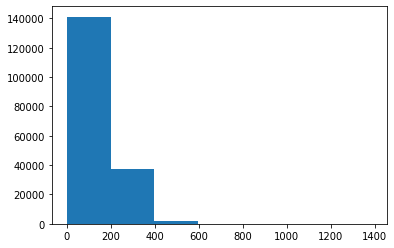

In [63]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token (out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [67]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   c o n v e n i e n c e   s a m p l e   o f   @   h e a l t h y   t e e n a g e   m a l e s   (   m e a n   s d   a g e   @   @   y e a r s   )   w a s   r e c r u i t e d   f r o m   t h e   m e m b e r s   o f   t w o   l o c a l   s p o r t s   c l u b s   .

Length of chars: 106

Vectorized chars:
[[ 5 11  7  6 21  2  6  4  2  6 11  2  9  5 15 14 12  2  7 17 13  2  5 12
   3 13 19  3  2  2  6  5 18  2 15  5 12  2  9 15  2  5  6  9 10  5 18  2
  19  2  5  8  9 20  5  9  8  2 11  8 16  4  3  2 10 17  8  7 15  3 13  2
  15  2 15 22  2  8  9  7 17  3 20  7 12  7 11  5 12  9 14  7  8  3  9 11
  12 16 22  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

## Create a character level embedding

In [69]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   c o n v e n i e n c e   s a m p l e   o f   @   h e a l t h y   t e e n a g e   m a l e s   (   m e a n   s d   a g e   @   @   y e a r s   )   w a s   r e c r u i t e d   f r o m   t h e   m e m b e r s   o f   t w o   l o c a l   s p o r t s   c l u b s   .

Embedded chars (after vectorization and embedding):
[[[-0.0445616   0.00296184 -0.04710728 ... -0.04810867 -0.04410199
   -0.01776725]
  [-0.02757604 -0.03107996 -0.04228288 ...  0.03377296  0.03592611
   -0.01227288]
  [ 0.023719   -0.03357582 -0.02664591 ... -0.04743496 -0.02475491
    0.04805343]
  ...
  [-0.01977994  0.0035311   0.00170355 ... -0.01754515 -0.00681068
    0.00977123]
  [-0.01977994  0.0035311   0.00170355 ... -0.01754515 -0.00681068
    0.00977123]
  [-0.01977994  0.0035311   0.00170355 ... -0.01754515 -0.00681068
    0.00977123]]]

Character embedding shape: (1, 290, 25)


## Build a convolutional 
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [70]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [72]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [73]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 31ms/step - loss: 1.2601 - accuracy: 0.4953 - val_loss: 1.0406 - val_accuracy: 0.5924
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9986 - accuracy: 0.6014 - val_loss: 0.9337 - val_accuracy: 0.6360
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9230 - accuracy: 0.6357 - val_loss: 0.8670 - val_accuracy: 0.6722


In [74]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.8846 - accuracy: 0.6567


[0.8846129775047302, 0.6566596031188965]

In [75]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19160911, 0.28376317, 0.24077055, 0.23209533, 0.05176185],
       [0.16192417, 0.7013121 , 0.00938618, 0.07851581, 0.04886183],
       [0.0922199 , 0.36960527, 0.15376051, 0.36033824, 0.02407606],
       ...,
       [0.01790685, 0.04265831, 0.18711166, 0.03602122, 0.716302  ],
       [0.02254094, 0.15650886, 0.12963511, 0.05911156, 0.63220346],
       [0.43463042, 0.3796282 , 0.09658465, 0.07534952, 0.01380718]],
      dtype=float32)

In [76]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [77]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.66596054547861,
 'precision': 0.6567175775494032,
 'recall': 0.6566596054547862,
 'f1': 0.6460169441704963}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (simmilar "model_1)
2. Create a character-level model (similar to model_3 with a slight modification
3. Combine 1 & 2 with a concatenate ('layers.concatenate')
4. Build a series of output layers on top of 3 similar to the paper
5. Construct a model which token and character level sequences as input and produces sequence label probabilities as output

In [78]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [79]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

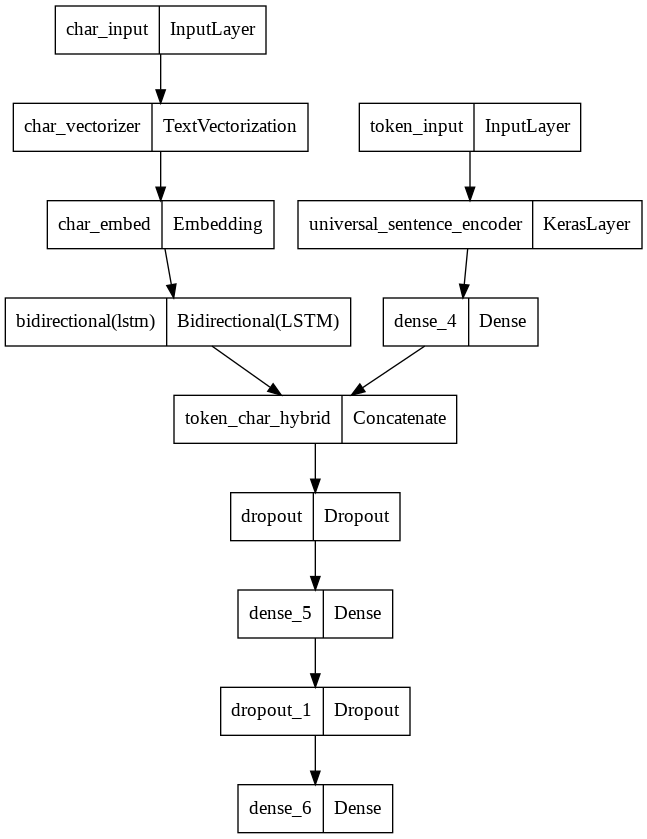

In [80]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [81]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [84]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 157s 268ms/step - loss: 0.9753 - accuracy: 0.6144 - val_loss: 0.7740 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 132s 235ms/step - loss: 0.7949 - accuracy: 0.6937 - val_loss: 0.7121 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 138s 246ms/step - loss: 0.7689 - accuracy: 0.7056 - val_loss: 0.6909 - val_accuracy: 0.7334


In [85]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.6974 - accuracy: 0.7335


[0.697401762008667, 0.7334502935409546]

In [86]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.40942764e-01, 3.71937931e-01, 2.46093306e-03, 1.78486347e-01,
        6.17209915e-03],
       [4.39231396e-01, 3.53736192e-01, 2.76765064e-03, 2.01772645e-01,
        2.49219243e-03],
       [2.87760228e-01, 1.01825275e-01, 4.48877215e-02, 5.23862958e-01,
        4.16637734e-02],
       ...,
       [7.39806506e-04, 1.10525219e-02, 4.38682362e-02, 2.10469545e-04,
        9.44128990e-01],
       [7.66776362e-03, 6.01279587e-02, 1.94499254e-01, 3.07066739e-03,
        7.34634340e-01],
       [2.48792127e-01, 4.11938399e-01, 2.41279572e-01, 3.86095308e-02,
        5.93804121e-02]], dtype=float32)

In [87]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [88]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.3450284655104,
 'precision': 0.7348184191581438,
 'recall': 0.733450284655104,
 'f1': 0.7321441380738049}